In [12]:
def human_format(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'.rstrip('0').rstrip('.')
    elif x >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return str(int(x))

In [13]:
# Focused visualization of Temporal Walk Benchmark results
import pickle
import matplotlib.pyplot as plt

results_dir = 'results/'

# Load the benchmark results
def load_results():
    cpu_results = {
        "edges": pickle.load(open(f"{results_dir}/result_edges_CPU.pkl", "rb")),
        "walks": pickle.load(open(f"{results_dir}/result_walks_CPU.pkl", "rb")),
        "max_walk_lens": pickle.load(open(f"{results_dir}/result_max_walk_lens_CPU.pkl", "rb")),
        "incremental": pickle.load(open(f"{results_dir}/result_incremental_sliding_CPU.pkl", "rb"))
    }
    
    gpu_results = {
        "edges": pickle.load(open(f"{results_dir}/result_edges_GPU.pkl", "rb")),
        "walks": pickle.load(open(f"{results_dir}/result_walks_GPU.pkl", "rb")),
        "max_walk_lens": pickle.load(open(f"{results_dir}/result_max_walk_lens_GPU.pkl", "rb")),
        "incremental": pickle.load(open(f"{results_dir}/result_incremental_sliding_GPU.pkl", "rb"))
    }
    
    return cpu_results, gpu_results

# Define edge and walk counts from the benchmark
edge_counts = [
    10_000, 50_000, 100_000, 500_000, 1_000_000, 2_000_000,
    5_000_000, 10_000_000, 20_000_000, 30_000_000, 40_000_000,
    50_000_000, 60_000_000
]

walk_counts = [
    10_000, 50_000, 100_000, 200_000, 500_000,
    1_000_000, 2_000_000, 5_000_000, 10_000_000
]

walk_lengths = list(range(10, 310, 10))

# Load results
cpu_results, gpu_results = load_results()

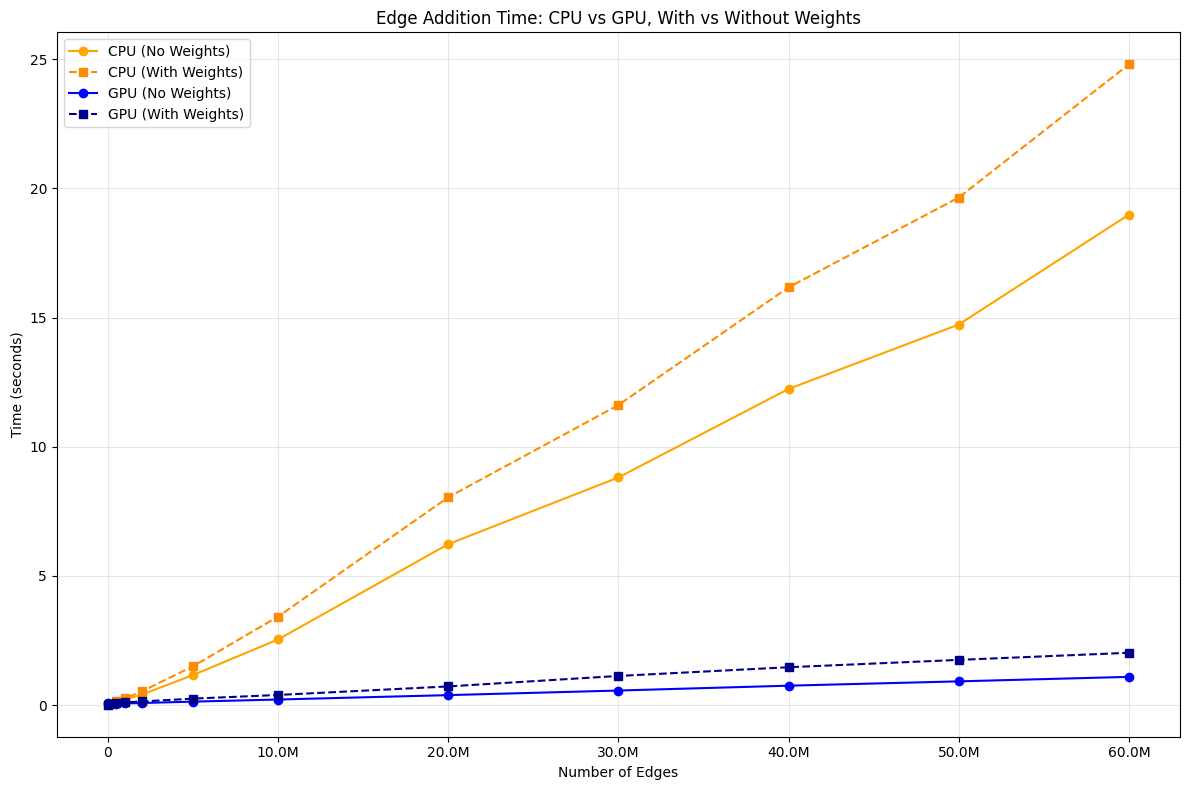

In [14]:
from matplotlib import ticker

# Plot 1: Edge Addition Time - With/Without Weights, CPU vs GPU
plt.figure(figsize=(12, 8))

# CPU - No weights
plt.plot(edge_counts, cpu_results["edges"]["edge_addition_time_without_weights"],
         'o-', color='orange', label="CPU (No Weights)")

# CPU - With weights
plt.plot(edge_counts, cpu_results["edges"]["edge_addition_time_with_weights"],
         's--', color='darkorange', label="CPU (With Weights)")

# GPU - No weights
plt.plot(edge_counts, gpu_results["edges"]["edge_addition_time_without_weights"],
         'o-', color='blue', label="GPU (No Weights)")

# GPU - With weights
plt.plot(edge_counts, gpu_results["edges"]["edge_addition_time_with_weights"],
         's--', color='darkblue', label="GPU (With Weights)")

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Number of Edges")
plt.ylabel("Time (seconds)")
plt.title("Edge Addition Time: CPU vs GPU, With vs Without Weights")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot1_edge_addition_comparison.png")
plt.show()

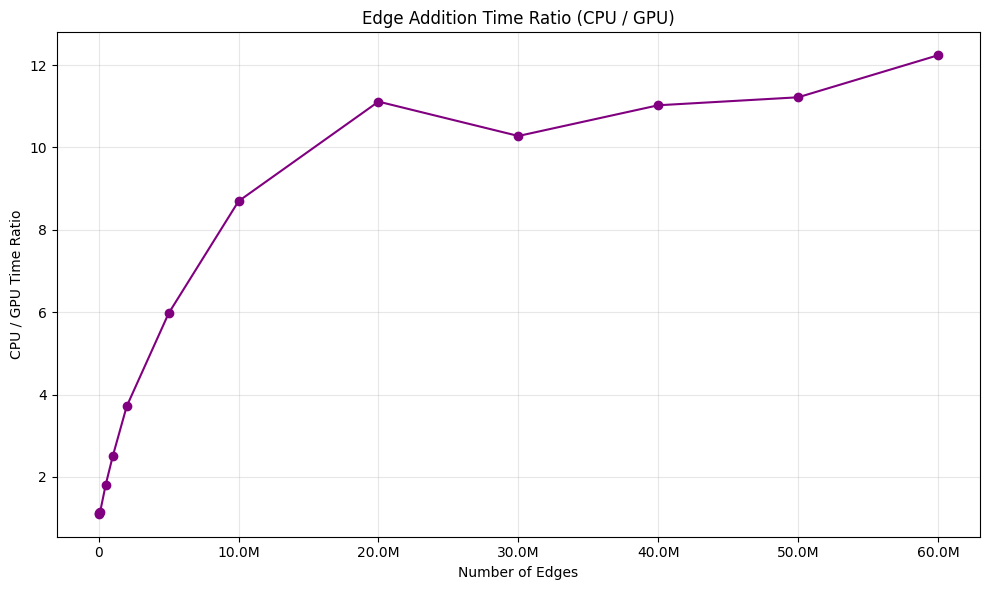

In [15]:
# Compute CPU/GPU ratios
ratios_no_weights = [
    c / g if g != 0 else float('inf')
    for c, g in zip(cpu_results["edges"]["edge_addition_time_with_weights"],
                    gpu_results["edges"]["edge_addition_time_with_weights"])
]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(edge_counts, ratios_no_weights, 'o-', color='purple')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Number of Edges")
plt.ylabel("CPU / GPU Time Ratio")
plt.title("Edge Addition Time Ratio (CPU / GPU)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/ratio_plot1_edge_addition_ratio.png")
plt.show()

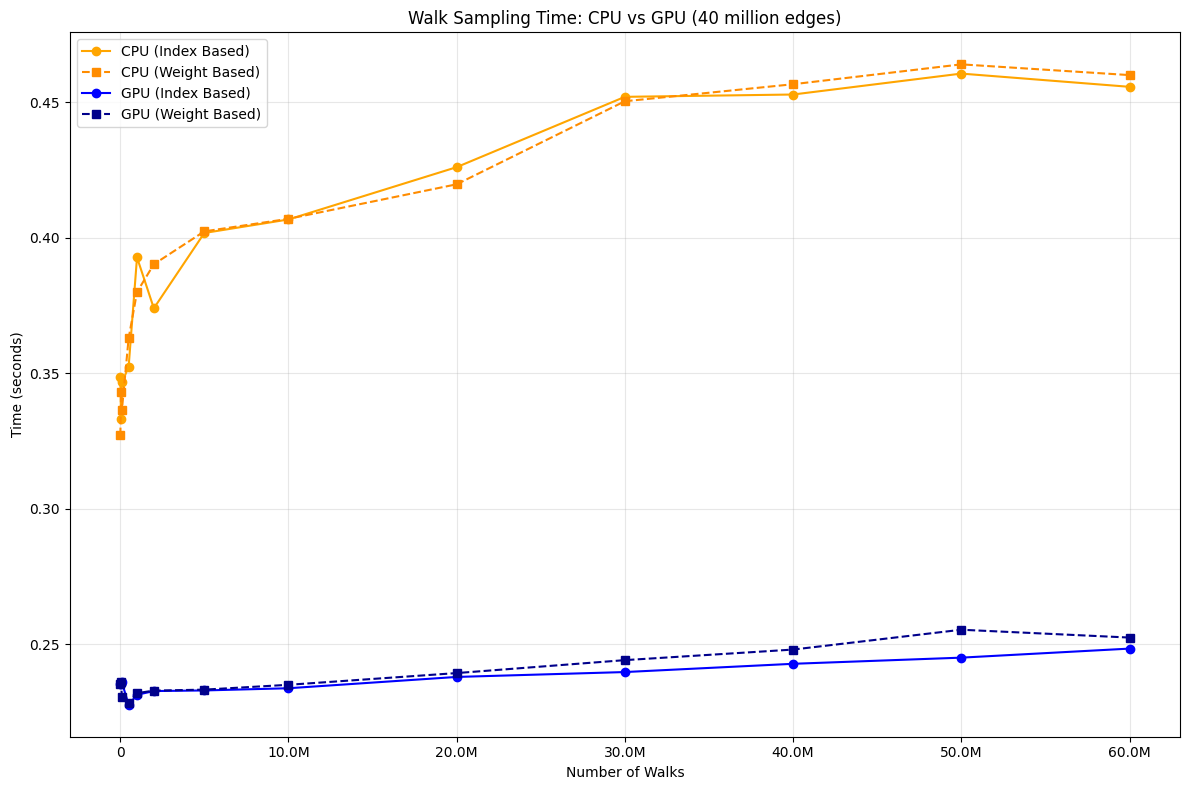

In [16]:
# Plot 2: Walk Sampling Time - With/Without Weights, CPU vs GPU
plt.figure(figsize=(12, 8))

# CPU - Index based
plt.plot(edge_counts, cpu_results["edges"]["walk_sampling_time_index_based"],
         'o-', color='orange', label="CPU (Index Based)")

# CPU - Weight based
plt.plot(edge_counts, cpu_results["edges"]["walk_sampling_time_weight_based"],
         's--', color='darkorange', label="CPU (Weight Based)")

# GPU - Index based
plt.plot(edge_counts, gpu_results["edges"]["walk_sampling_time_index_based"],
         'o-', color='blue', label="GPU (Index Based)")

# GPU - Weight based
plt.plot(edge_counts, gpu_results["edges"]["walk_sampling_time_weight_based"],
         's--', color='darkblue', label="GPU (Weight Based)")

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Number of Walks")
plt.ylabel("Time (seconds)")
plt.title("Walk Sampling Time: CPU vs GPU (40 million edges)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot2_walk_sampling_comparison.png")
plt.show()

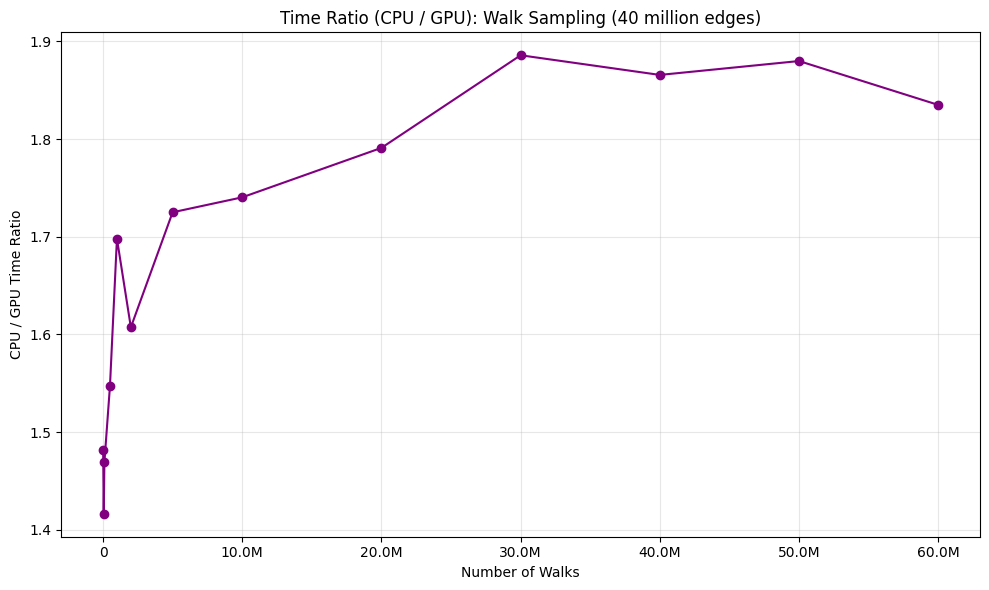

In [17]:
# CPU and GPU walk sampling times (Index-based) — Plot 2
cpu_times = cpu_results["edges"]["walk_sampling_time_index_based"]
gpu_times = gpu_results["edges"]["walk_sampling_time_index_based"]
ratios = [c / g if g != 0 else float('inf') for c, g in zip(cpu_times, gpu_times)]

plt.figure(figsize=(10, 6))
plt.plot(edge_counts, ratios, marker='o', linestyle='-', color='purple')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Number of Walks")
plt.ylabel("CPU / GPU Time Ratio")
plt.title("Time Ratio (CPU / GPU): Walk Sampling (40 million edges)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/ratio_plot2_walk_sampling.png")
plt.show()

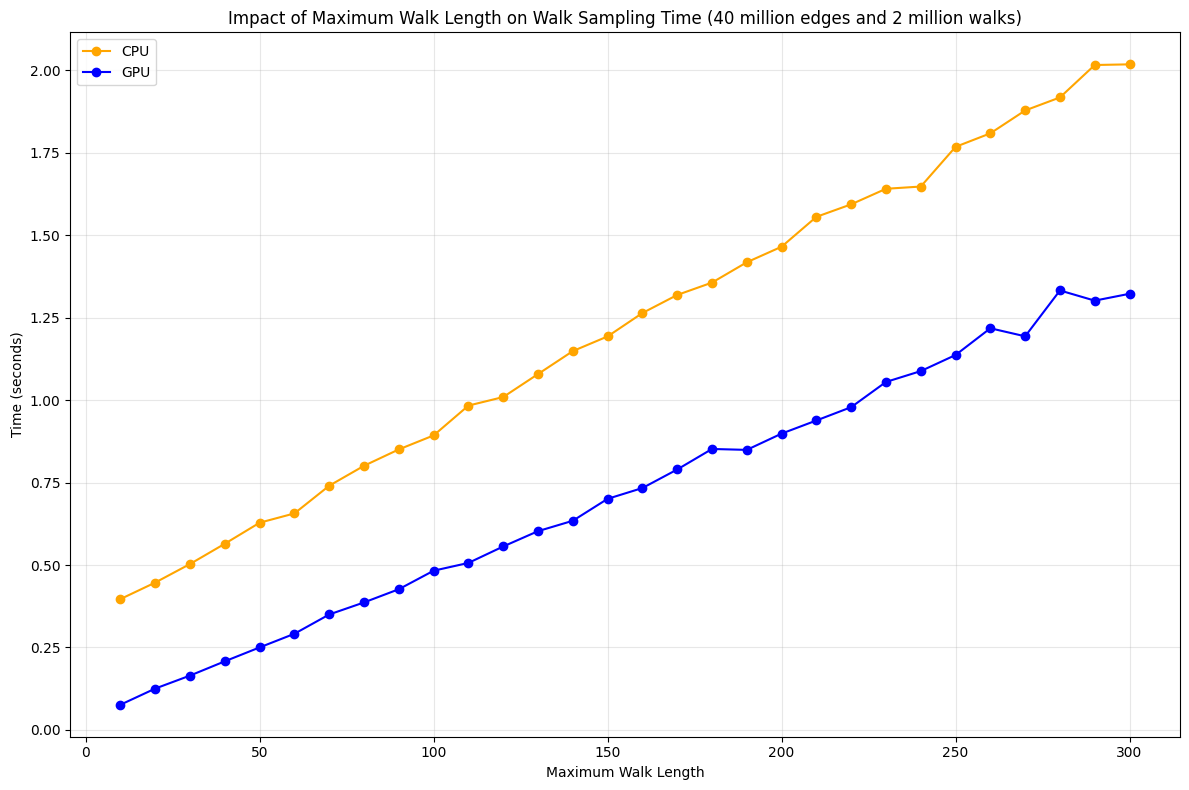

In [18]:
# Plot 3: Walk Length Impact (Index-based only)
plt.figure(figsize=(12, 8))

# CPU walk sampling time
plt.plot(walk_lengths, cpu_results["max_walk_lens"]["walk_sampling_time"],
         'o-', color='orange', label="CPU")

# GPU walk sampling time
plt.plot(walk_lengths, gpu_results["max_walk_lens"]["walk_sampling_time"],
         'o-', color='blue', label="GPU")

plt.xlabel("Maximum Walk Length")
plt.ylabel("Time (seconds)")
plt.title("Impact of Maximum Walk Length on Walk Sampling Time (40 million edges and 2 million walks)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot3_walk_length_impact.png")
plt.show()

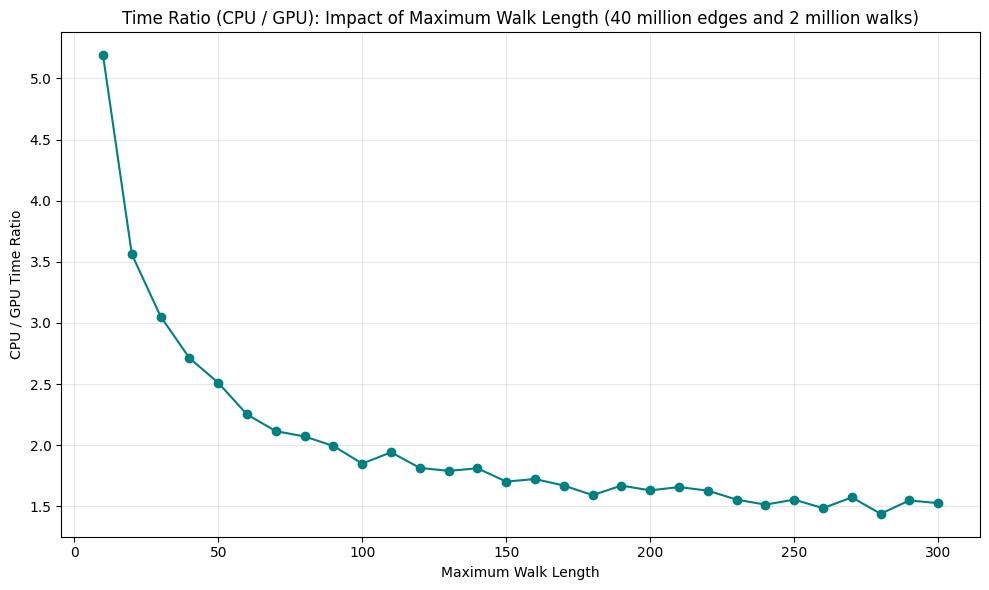

In [19]:
# CPU and GPU times — Plot 3
cpu_times = cpu_results["max_walk_lens"]["walk_sampling_time"]
gpu_times = gpu_results["max_walk_lens"]["walk_sampling_time"]
ratios = [c / g if g != 0 else float('inf') for c, g in zip(cpu_times, gpu_times)]

plt.figure(figsize=(10, 6))
plt.plot(walk_lengths, ratios, marker='o', linestyle='-', color='teal')
plt.xlabel("Maximum Walk Length")
plt.ylabel("CPU / GPU Time Ratio")
plt.title("Time Ratio (CPU / GPU): Impact of Maximum Walk Length (40 million edges and 2 million walks)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/ratio_plot3_walk_length.png")
plt.show()

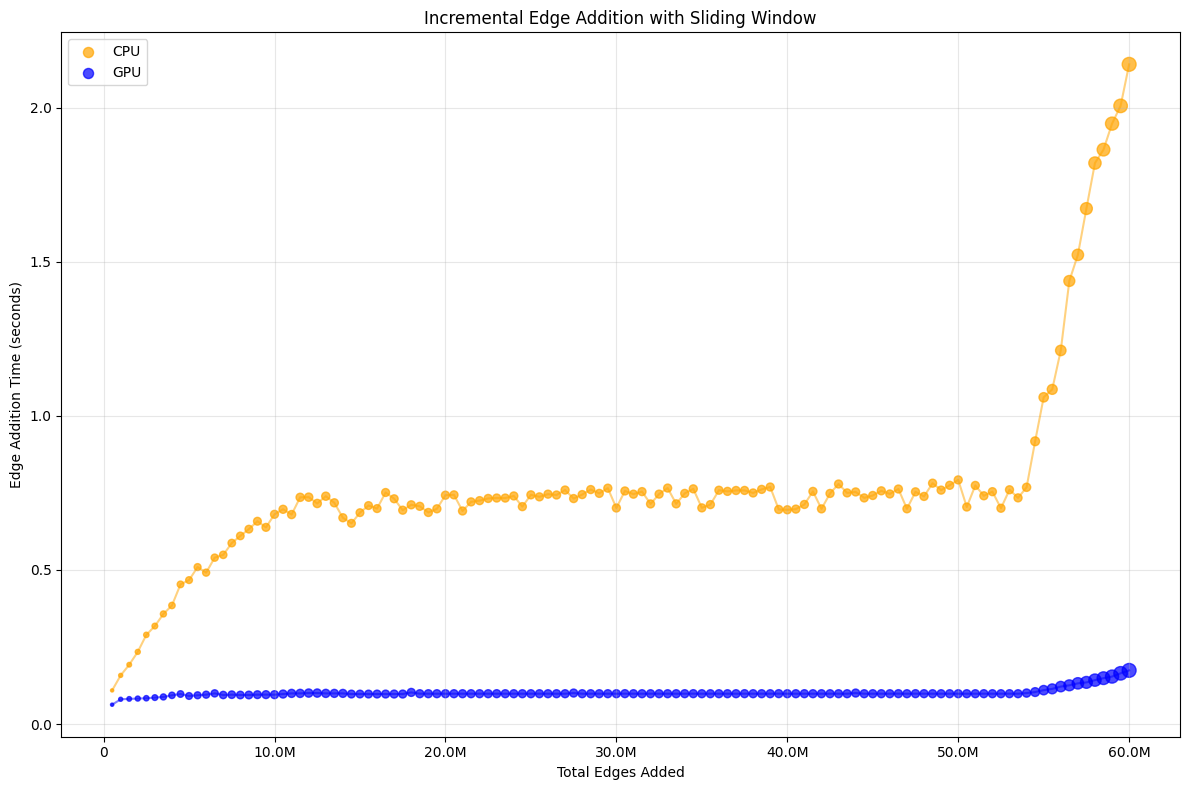

In [20]:
# Plot 4: Incremental Edge Addition with Active Edges
plt.figure(figsize=(12, 8))

# Create scatter plots with size indicating active edges
cpu_total_edges = cpu_results["incremental"]["total_edges"]
cpu_active_edges = cpu_results["incremental"]["active_edges"]
cpu_edge_addition_time = cpu_results["incremental"]["edge_addition_time"]

gpu_total_edges = gpu_results["incremental"]["total_edges"]
gpu_active_edges = gpu_results["incremental"]["active_edges"]
gpu_edge_addition_time = gpu_results["incremental"]["edge_addition_time"]

# Calculate normalized size for scatter points
max_active = max(max(cpu_active_edges), max(gpu_active_edges))
cpu_sizes = [100 * active / max_active for active in cpu_active_edges]
gpu_sizes = [100 * active / max_active for active in gpu_active_edges]

# Plot the data
sc_cpu = plt.scatter(cpu_total_edges, cpu_edge_addition_time,
                     s=cpu_sizes, c='orange', alpha=0.7, label="CPU")
sc_gpu = plt.scatter(gpu_total_edges, gpu_edge_addition_time,
                     s=gpu_sizes, c='blue', alpha=0.7, label="GPU")

# Add lines to connect points
plt.plot(cpu_total_edges, cpu_edge_addition_time, 'orange', alpha=0.5)
plt.plot(gpu_total_edges, gpu_edge_addition_time, 'blue', alpha=0.5)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Total Edges Added")
plt.ylabel("Edge Addition Time (seconds)")
plt.title("Incremental Edge Addition with Sliding Window")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot4_incremental_edge_addition.png")
plt.show()

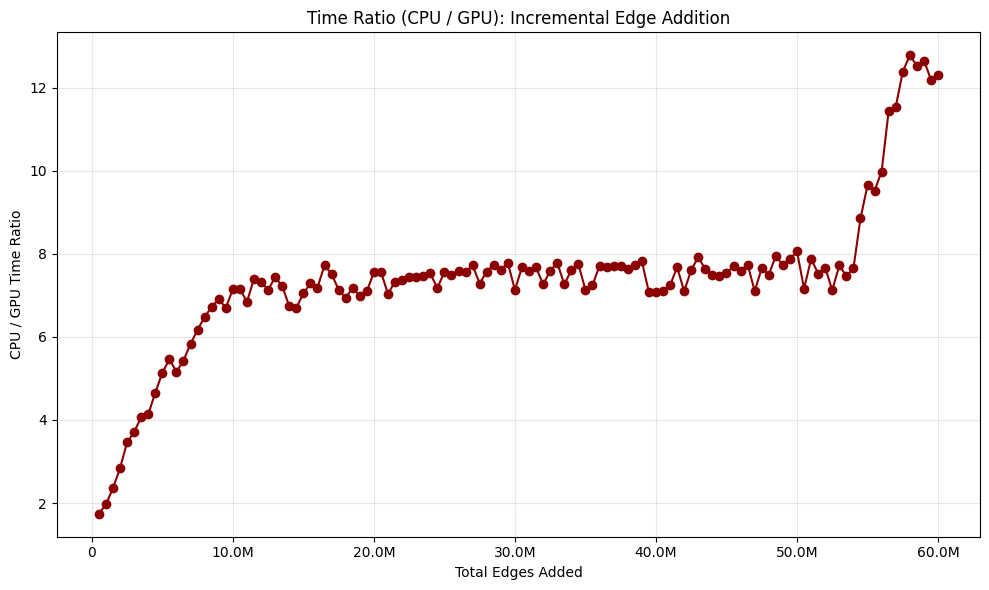

In [21]:
# CPU and GPU times — Plot 4
cpu_times = cpu_results["incremental"]["edge_addition_time"]
gpu_times = gpu_results["incremental"]["edge_addition_time"]
ratios = [c / g if g != 0 else float('inf') for c, g in zip(cpu_times, gpu_times)]

plt.figure(figsize=(10, 6))
plt.plot(cpu_results["incremental"]["total_edges"], ratios, marker='o', linestyle='-', color='darkred')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Total Edges Added")
plt.ylabel("CPU / GPU Time Ratio")
plt.title("Time Ratio (CPU / GPU): Incremental Edge Addition")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/ratio_plot4_incremental_edge_addition.png")
plt.show()

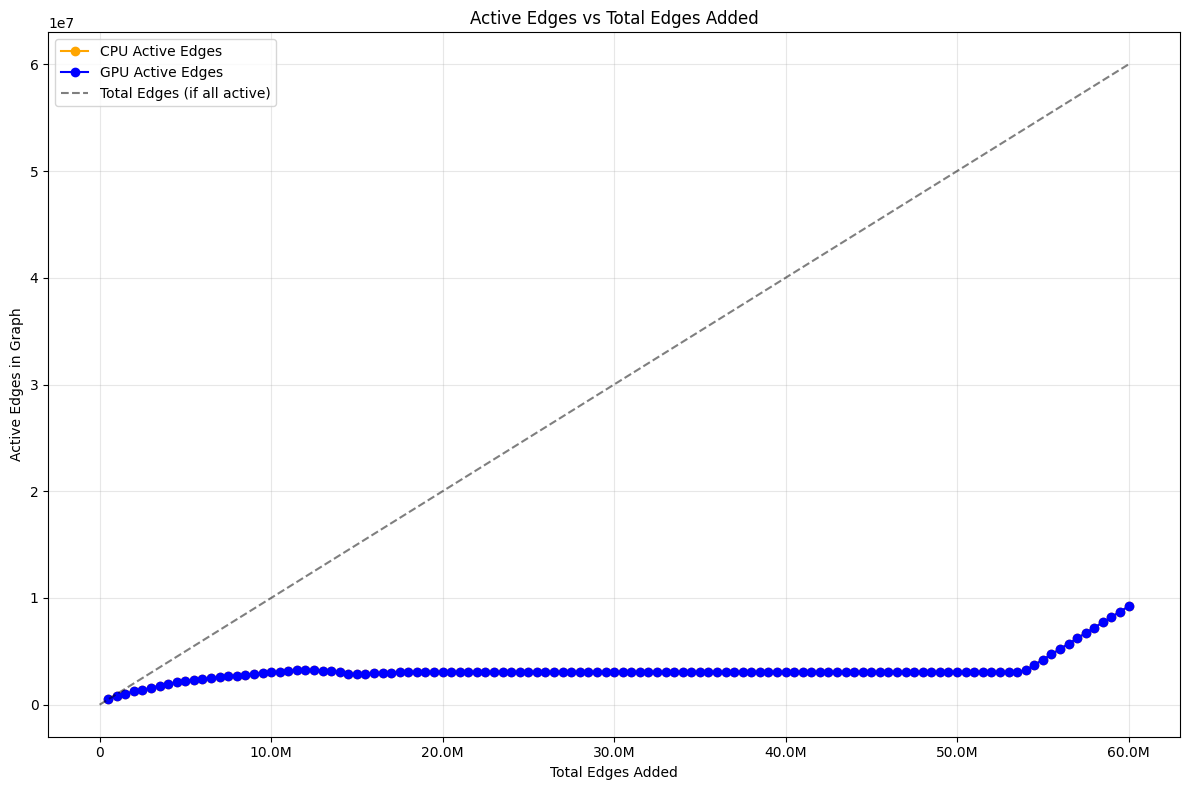

In [22]:
plt.figure(figsize=(12, 8))

# Plot active edges vs total edges
plt.plot(cpu_total_edges, cpu_active_edges, 'o-', color='orange', label="CPU Active Edges")
plt.plot(gpu_total_edges, gpu_active_edges, 'o-', color='blue', label="GPU Active Edges")

# Add a reference line showing total edges (y=x line)
max_total = max(max(cpu_total_edges), max(gpu_total_edges))
plt.plot([0, max_total], [0, max_total], 'k--', alpha=0.5, label="Total Edges (if all active)")

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Total Edges Added")
plt.ylabel("Active Edges in Graph")
plt.title("Active Edges vs Total Edges Added")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot5_total_vs_active_edges.png")
plt.show()